[方法指引](https://docs.google.com/document/d/1nPLGlZV4Zyc6gQkpfBicruGNJMhlB7ZlPID_-vudlQU/edit?usp=sharing)
## 一、 探索外觀特徵與科之間的關係
### 建立簡易的分科模型，提供後續GradCam分析方法，視覺化檢視分科特徵

- 為了進一步了解物種的外觀特徵與科之間的關係，我們首先以代表外觀特徵的 latent vector 為輸入資料，訓練簡單的神經網路模型學習分科，並評估分科表現。為了後續解讀方便，我們將外觀特徵值轉換為非負值。

- 做法是先將對應每張標本影像的 n 維特徵重複堆疊為 n*2 維，保留前 n 維裡的正值，與後 n 維裡的負值並取絕對值，其餘維度設為 0。如此即會得到內容全為非負值的特徵(embeddings)

- 以此為 input，訓練僅兩層全連接 hidden layers (每層各m個神經元) 的簡單模型，學習分科 (249科)，在測試資料集中可達到 -% top-1 accuracy。

In [1]:
import os, time, random, glob
import datetime
import numpy as np 
import pandas as pd
from pathlib import Path
# import PIL
import skimage.io
import skimage.transform

import torch
from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
from torch.autograd import Variable
import torchvision 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
# plt.style.use('seaborn-whitegrid')
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(12,10)})
path_root =  '/home/esslab/AI_projects/yunghui/mae'

path_meta = Path('meta')
path_meta.mkdir(exist_ok=True, parents=True)
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

In [2]:
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from umap import UMAP

# Prepare data

1. stack the n-dimensional features corresponding to each specimen image into n*2 dimensions
    - keep the positive values in the first n dimensions, take the absolute values of the negative values in the next n dimensions, 
    - and set the remaining dimensions to 0. 
    - This will result in the appearance features with all non-negative values.  
2. assign the samples in proportion to the sample type to ensure that small samples are assigned to the training dataset first, 
    - and that the same proportion is assigned to the training and validation datasets.
    - select the family with more than 3 species only.

In [3]:
encoder_version='eBirdPT_VSC' # 'iNatFT', 'eBirdFT' or 'eBirdPT', 'eBirdPT_VSC'
norm_pixel = 'off' # 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBirdTop100' #  'iNat', 'eBird', 'eBirdTop100'
path_model = Path('output_dir')

print(f'Encoder  : {encoder_version}')
if encoder_version=='iNatFT':
    ck = path_model/'ebird_NPon_FT_cls_vit_base_checkpoint-99.pth'   #　iNaturalist finetuned MAE
    n_classes = 1486
elif encoder_version=='eBirdPT':
    ck = path_model/'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'   #　eBird pretrained MAE
    n_classes =1486
elif encoder_version=='eBirdFT':
    ck = path_model/'ebird_NPon_eBirdFT_cls11186_vit_base_checkpoint-149.pth'  #　eBird finetuned MAE
    n_classes = 11186
elif encoder_version=='eBirdPT_VSC':
    epoch_=400
    ck = path_model/f'VSC_A001_Wr1_Wp5e-3_W40_LRe-5_checkpoint-{epoch_}.pth'  #　eBird finetuned MAE_VSC

v_embedding = f'NP{norm_pixel}(Pretrain)_{encoder_version}_{token}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {v_embedding}')




Encoder  : eBirdPT_VSC
Embedding version : NPoff(Pretrain)_eBirdPT_VSC_cls(Encoder)_eBirdTop100(Data)


### Load meta

In [6]:
%%time

data_path = '../../shared/iNaturalist_2021'

if data_src == 'eBird':
    val_data = 'val_ebird'
    meta_data =  '../../shared/iNaturalist_2021/meta/val_ebird.csv'
elif data_src == 'iNat':
    val_data = 'val'
    meta_data =  '../../shared/iNaturalist_2021/meta/val.csv'
elif  data_src == 'eBirdTop100':
    data_path = '../../shared/eBird/download_ebird/downloaded'
    val_data = 'jpg_top100'
    meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.feather'

print(f'Meta data :  "{Path(meta_data).name}"')

Meta data :  "jpg_top100_meta5.feather"
CPU times: user 420 µs, sys: 577 µs, total: 997 µs
Wall time: 819 µs


In [7]:
%%time

if "feather" in meta_data:
    df_meta =  pd.read_feather(meta_data)
else:
    df_meta =  pd.read_csv(meta_data, index_col=0 )

CPU times: user 2.21 s, sys: 3.05 s, total: 5.26 s
Wall time: 2.3 s


In [9]:
%%time
# Establish sp_id  
if data_src == 'eBirdTop100':
    col_obj2cat = ['Format', 'Accessory', 'Asset_State', 'isInternalUser', 'mediaDownloadUrl', 'Playback', 'Microphone', 'Recorder', 'Taxon_Category', 
                   'Age/Sex', 'Asset_Tags', 'Order', 'Behaviors', 'Country', 'Parent_Dir', 'Family', 'Background_Species', 'Genus', 'State', 'County']
    for col in col_obj2cat :
        df_meta[col] =  df_meta[col].astype('category') 
    
    col_label = ['Label'] 
    col_basic = ['ML_Catalog_Number', 'Dir_FName']
    col_file = ['Dir_FName', 'Parent_Dir', 'Sci_N']
    col_taxon = ['Order', 'Family', 'Genus', 'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category']
    col_geo = ['Country', 'Latitude', 'Longitude']
    col_time = ['Year', 'Month', 'Day']
    col_sel = col_label + col_basic + col_taxon + col_geo + col_time
    df_meta = df_meta[col_sel].copy()
elif data_src == 'iNat' or  data_src == 'eBird':
    df_meta.set_axis(df_meta.columns.str.capitalize(), axis='columns', inplace=True)
    df_meta.rename({'Scientific Name':'Sci_Name'}, axis='columns', inplace=True)
    df_meta['Sci_Name'] = df_meta.Genus + '_' + df_meta.Specific_epithet
    df_meta.sort_values(by=['File_name'], inplace=True)
    
print(f'# of Order : {df_meta.Order.nunique()}')
print(f'# of Family : {df_meta.Family.nunique()}')
print(f'# of Genus: {df_meta.Genus.nunique()}')

print(df_meta.columns)

# of Order : 41
# of Family : 249
# of Genus: 2295
Index(['Label', 'ML_Catalog_Number', 'Dir_FName', 'Order', 'Family', 'Genus',
       'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category',
       'Country', 'Latitude', 'Longitude', 'Year', 'Month', 'Day'],
      dtype='object')
CPU times: user 4.43 s, sys: 2.58 s, total: 7 s
Wall time: 7.02 s


In [10]:
# val_data = 'ebird_finetune/train'
# imgs_path = Path(data_path, val_data)
# # imgs_path = Path('../../shared/iNaturalist_2021/val_ebird')
# print(imgs_path)
# files_path_ = [f for f in imgs_path.glob('**/*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

# # exlude .ipynb files
# files_path_ = [f for f in files_path_ if not f.name.startswith('.')] 
# files_path_.sort()

# print(f'Meta data :  "{Path(meta_data).name}"')

896555


#### get file path

In [12]:
if data_src == 'eBirdTop100':
    files_path_  = list(data_path + '/' +  val_data + '/' + df_meta.Dir_FName	+ '.jpg')
    labels = df_meta.Label.values
    assert len(files_path_) == len(labels)
    assert  df_meta.Label.dtype == 'int64'
else:
    imgs_path = Path(data_path,val_data)
    files_path_ = [f for f in imgs_path.glob('**/*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    files_path_.sort()
    # exlude .ipynb files
    files_path_ = [f for f in files_path_ if not f.name.startswith('.')] 

print(len(files_path_ ))

896555


### Get gradients from embeddings

In [13]:
%%time
file_ = f'embeddings_{v_embedding}.npz'

# print(f'{file_}')
# np.savez_compressed(path_embeddings/file_, embedding=embeddings.cpu().numpy() )
# print(f'{file_} saved')
# np.save(path_embeddings.joinpath(file_) , embeddings)
embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings .shape)

n, dim = embeddings.shape
print(f'Data size : {n}, Dimension : {dim}')

(896555, 768)
Data size : 896555, Dimension : 768
CPU times: user 14.1 s, sys: 36 s, total: 50.1 s
Wall time: 50.2 s


In [14]:
# filter label > 0
mask_label_positive = df_meta.Label >= 0
# embeddings = embeddings_ori[mask_label_positive]
# print(embeddings.shape)

labels = df_meta.Label[mask_label_positive].values
print(labels.shape)

# assert len(embeddings) == len(labels)

(896195,)


#### Load Embeddings (Latent Vectors)
- then the dimensions are stacked to turn negative values into positive values

In [15]:
f_pos = np.where(embeddings > 0, embeddings, 0)               # 保留正值，將其他維(負值)設為0 
f_neg = np.abs(np.where(embeddings < 0, embeddings, 0))       # 保留負值，將其他維(正值)設為0，最後取絕對值  
embeddings_stacked = np.concatenate((f_pos, f_neg), axis=1)   # 將原本的n為堆疊為n*2維 shape = (896195, 1536)
print(embeddings_stacked.shape)

_, dim_stacked = embeddings_stacked.shape
print(dim_stacked)

(896555, 1536)
1536


#### split dataset  

In [16]:
n_sp_Family = (df_meta[mask_label_positive][['Family', 'Label']]
               .drop_duplicates(subset=['Family', 'Label'])
               .reset_index(drop=True)
               .groupby(['Family']).count()
               .set_axis(['n_species'], axis=1))
n_sp_Family
n = 3 
print(f"There are {len(n_sp_Family.query('n_species<@n'))} families with less than {n} species")

# n=1
# fam_1sp = list(n_sp_Family.query('n_species==@n').index.values)
# print(f"There are {len(fam_1sp)} families with  {n} species")

n=1
fam_gt1sp = list(n_sp_Family.query('n_species>@n').index.values)
print(f"There are {len(fam_gt1sp)} families with more than {n} species")

There are 58 families with less than 3 species
There are 210 families with more than 1 species


In [19]:
mask_fam_gt1sp =  (df_meta.Family.isin(fam_gt1sp)) & (df_meta.Label>=0)
df_meta[mask_fam_gt1sp]

,Label,ML_Catalog_Number,Dir_FName,Order,Family,Genus,SCI_NAME_2021,Sci_Name,Parent_Species,Taxon_Category,Country,Latitude,Longitude,Year,Month,Day
0,3090,114289801,Acanthisittidae/Acanthisitta_chloris_0_114289801,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,New Zealand,-44.1665,169.2763,2016.0,1.0,2.0
1,3090,114289821,Acanthisittidae/Acanthisitta_chloris_0_114289821,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,New Zealand,-44.1665,169.2763,2016.0,1.0,2.0
2,3090,114404941,Acanthisittidae/Acanthisitta_chloris_0_114404941,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,New Zealand,-46.9317,168.1317,2018.0,9.0,5.0
3,3090,114404951,Acanthisittidae/Acanthisitta_chloris_0_114404951,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,New Zealand,-46.9317,168.1317,2018.0,9.0,5.0
4,3090,115495451,Acanthisittidae/Acanthisitta_chloris_0_115495451,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris,Species,New Zealand,-43.7185,170.0868,2018.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896550,9660,59630711,Zosteropidae/Zosterornis_whiteheadi_0_59630711,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi,Species,Philippines,14.0547,121.4474,2017.0,3.0,13.0
896551,9660,59630721,Zosteropidae/Zosterornis_whiteheadi_0_59630721,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi,Species,Philippines,14.0547,121.4474,2017.0,3.0,13.0
896552,9660,63554951,Zosteropidae/Zosterornis_whiteheadi_0_63554951,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi,Species,Philippines,16.3351,120.5607,2017.0,7.0,16.0
896553,9660,79738531,Zosteropidae/Zosterornis_whiteheadi_0_79738531,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi,Species,Philippines,13.2833,123.6727,2017.0,12.0,30.0


In [20]:
family_list = list(df_meta.Family.dropna().unique())
family_list.sort()
print(len(family_list))

fam2digit = dict(zip(family_list, range(len(family_list))))
fam2digit.items()


249


dict_items([('Acanthisittidae', 0), ('Acanthizidae', 1), ('Accipitridae', 2), ('Acrocephalidae', 3), ('Aegithalidae', 4), ('Aegithinidae', 5), ('Aegothelidae', 6), ('Alaudidae', 7), ('Alcedinidae', 8), ('Alcidae', 9), ('Anatidae', 10), ('Anhimidae', 11), ('Anhingidae', 12), ('Anseranatidae', 13), ('Apodidae', 14), ('Apterygidae', 15), ('Aramidae', 16), ('Ardeidae', 17), ('Artamidae', 18), ('Atrichornithidae', 19), ('Balaenicipitidae', 20), ('Bernieridae', 21), ('Bombycillidae', 22), ('Brachypteraciidae', 23), ('Bucconidae', 24), ('Bucerotidae', 25), ('Bucorvidae', 26), ('Buphagidae', 27), ('Burhinidae', 28), ('Cacatuidae', 29), ('Calcariidae', 30), ('Callaeidae', 31), ('Calyptomenidae', 32), ('Calyptophilidae', 33), ('Campephagidae', 34), ('Capitonidae', 35), ('Caprimulgidae', 36), ('Cardinalidae', 37), ('Cariamidae', 38), ('Casuariidae', 39), ('Cathartidae', 40), ('Certhiidae', 41), ('Chaetopidae', 42), ('Charadriidae', 43), ('Chionidae', 44), ('Chloropseidae', 45), ('Ciconiidae', 46)

- 訓練時使用所有資料

In [21]:
family_  = df_meta.groupby(['Family']).count().query('ML_Catalog_Number==1').Label.index[0]
print(f'Family which is only has 1 data : {family_}, Extinctd')

mask_data_more_than1 = df_meta.Family != family_

Family which is only has 1 data : Mohoidae, Extinctd


In [22]:
from sklearn.model_selection import train_test_split
# mask_fam_gt1sp =  (df_meta.Family.isin(fam_gt1sp)) & (df_meta.Label>=0)  #  (Number of species of each family >1) & (Label>=0)

X = embeddings_stacked[mask_label_positive & mask_data_more_than1]
y = df_meta[mask_label_positive & mask_data_more_than1].Family.map(fam2digit).values  # 科名編碼
X_train, X_valid, y_train, y_valid  = train_test_split(X, y, test_size=0.4, random_state=10, stratify=y)  # Samples are taken in proportion to the class of y

In [23]:
# Check that the proportion and number of cuts in each category are consistent between the training and validation datasets
n_taxon_unit_trained = np.unique(y).size
print(f'Number of taxon_unit : {n_taxon_unit_trained}')

print(f'X_train:{X_train.shape}, y_train:{y_train.shape},\nX_valid:{X_valid.shape},  y_valid:{y_valid.shape}')
# print(f'Class Pro of y_train:\n{np.round(np.bincount(y_train)/y_train.size,3)}')
# print(f'Class Pro of y_valid:\n{np.round(np.bincount(y_valid)/y_valid.size, 3)}')  
print(f'Class count of y_train:\n{np.bincount(y_train)}')  # 檢視各類別切分數量，0~96
print(f'Class count of y_valid:\n{np.bincount(y_valid)}') 

# save meta data 
# dict_data = {'X_train':X_train, 'y_train':y_train, 'X_valid':X_valid, 'y_valid':y_valid}
# for k, v in dict_data.items():
#     np.save(f'meta/{k}.npy', v)

Number of taxon_unit : 248
X_train:(537716, 1536), y_train:(537716,),
X_valid:(358478, 1536),  y_valid:(358478,)
Class count of y_train:
[  120  2740 15968  2295   865   247   233  5096  4535  1614 16368   180
   239    60  4274    94   158  5743  1561    29    60   235   203   271
  2080  2753   120   123   596  1175   427   180   219    38  2945   692
  3607  3552   120   128   594   883   120  4796    64   540  1273   404
   328  5368   448    50   290 12549   385   859   120  7986  3176  2683
  7305   179  1759  1455  1385    60    60    60    22  2471  5343    22
    39   459    60  4952   163   368   272 12035 13853  1163   321   953
  1834  1154   787   135   238  5590  1003    68    16    60    60  7542
   162    41   443   119   586  2665  9600  6251    60  1608  1819    89
   576  1655  1457  1705   368    12    91   208  6129   120  1621   151
  2168   184     6     0   180   956  2596  5230 16346  1086  5431   247
    60    93    60   349   401   593  1526    60    95  1304

#### define class Dataset

In [24]:
# 準備訓練用的Dataset
class eBirdEmbeddingsDataset(Dataset):
    def __init__(self, X, y, normalize=False):
        """ Dataset for Classification Model
            image_root: path to image file
            X : ndarray, list. embeddings (n, dim)
            y : ndarray, list.  encode of taxon unit
        """         
        self.X,  self.y= torch.tensor(X), torch.tensor(y)
        self.normalize = normalize  

    def __getitem__(self, index):
        feature = self.X[index]
        label = self.y[index]
        if self.normalize:
            def normalMinMax(features):        # Scales the value to between (0, 1)
                features_normal = (features - features.min()) / features.max()
                return features_normal
            feature = normalMinMax(feature)     
        return feature, label
    
    def __len__(self):
        return len(self.y)
        
    # help to get images for visualizing
    def getbatch(self, indices):
        features = []
        labels = []
        for index in indices:
            feature, label = self.__getitem__(index)
            features.append(feature)
            labels.append(label)
        return torch.stack(features), labels


class ImgDataset(Dataset):
    ''' Dataset used to sample and confirm the original image files
        X: ImagePath
        y: Imagelabel(Family, Genus ,Specie Name etc...)
    '''
    def __init__(self, X, y):
        self.ImgNames  = np.asarray(X)                   
        self.labels = np.asarray(y)
        # Transform Images form numpy.ndarray (in the shape [H, W, C], values in the range [0, 255])  to
        #                       torch.FloadTensor (in the shape [C, H, W], values in the range [0, 1])
        self.to_tensor = transforms.ToTensor()          
        
    def __getitem__(self, index):
        img_Name = self.ImgNames[index]
#         image = PILImage.open(img_Name)                #  PIL Image reads the channel of the image as (c, w, h)
        image = skimage.io.imread(img_Name)              #  skimage.io reads the channel of the image as (w, h, c) 
        image = skimage.transform.resize(image, (128,128))
        image = self.to_tensor(image)                    
        label  = self.labels[index]
        return image, label
    
    def __len__(self):
        return len(self.labels)
    
    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), labels

# 一次預讀取讀取所有影像 
# X = moth_meta.ImgPath
# y = moth_meta.Family
# img_set = ImgDataset(X=X, y=y)

In [25]:
### 設定參數
batch_size  = 512
num_workers = 10
pin_memory  = True
drop_last   = True

# 客製Dataset載入資料
train_set =  eBirdEmbeddingsDataset(X=X_train, y=y_train)
valid_set =  eBirdEmbeddingsDataset(X=X_valid, y=y_valid )

# DataLoader將資料把包成批次
train_loader = DataLoader(dataset=train_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory, drop_last=drop_last)
valid_loader = DataLoader(dataset=valid_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)

# # 檢視資料形狀、大小
print(f'Train size : {len(train_set):5d}, iter_size: {len(train_loader):4d}')
print(f'Valid size : {len(valid_set):5d}, iter_size: {len(valid_loader):4d}')

features, labels = next(iter(train_loader))
print('Train data set:', features.shape, labels.shape)   # (batch_size, channel, w, h) 
features, labels = next(iter(valid_loader))
print('Valid data set:', features.shape, labels.shape)   # (batch_size, channel, w, h) 

Train size : 537716, iter_size: 1050
Valid size : 358478, iter_size:  701
Train data set: torch.Size([512, 1536]) torch.Size([512])
Valid data set: torch.Size([512, 1536]) torch.Size([512])


## Build the mold with simple two-layer fully connected layer

In [26]:
# Define model
 
n_classes = 249
n_neurons = 256

class Family_Predictor(nn.Module):
    def __init__(self, in_features=dim*2 , n_neurons=n_neurons, n_classes=n_classes ):
        super().__init__()
#         super().__init__()
        self.family_Predictor = nn.Sequential(
            nn.Linear(in_features, n_neurons),
            nn.LeakyReLU(negative_slope=0.02, inplace=True),
            nn.Linear(n_neurons, n_classes),
        )

    def forward(self, x):
        pre = self.family_Predictor(x)
        return pre 
    
model = Family_Predictor(in_features=dim*2 , n_neurons=n_neurons, n_classes=n_classes) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Family_Predictor(
  (family_Predictor): Sequential(
    (0): Linear(in_features=1536, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.02, inplace=True)
    (2): Linear(in_features=256, out_features=249, bias=True)
  )
)

### define  functions for training




In [29]:
model_name = f'Family_Predictor_Batch{batch_size}_VSC' 
path_model = Path('meta/family_Predictor')
if not path_model.exists():
    path_model.mkdir(exist_ok=True, parents=True)
path = path_model/f'{model_name}.pth'

# 呼叫模型檢查點(Checkpoint)儲存與載入函式
def save_checkpoint(model, optimizer=None, path=None, epoch=None, best_metric=None):
    state = {'model_state_dict'    : model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'epoch':epoch,
             'best_metric': best_metric}
    torch.save(state , path)

def load_checkpoint(model, path, optimizer=None):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch_ = checkpoint['epoch']
    best_metric_ = checkpoint['best_metric']
    
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(optimizer)

    print(f'best__metric : {best_metric_:.4f}')
    print(f'{model_name}.pth loaded!')
    return model

In [30]:
del train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log

NameError: name 'train_log' is not defined

In [31]:
# 檢查變數是否已命名
try:
    train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log
    print('log file has bean setted')
except NameError:
    train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log  = [], [], [], [], []
    print('log file resetted:\n    train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log')

# 檢查資料夾是否已建立
logRoot =  path_model
if not os.path.isdir(f'{logRoot}'):
    os.mkdir(f'{logRoot}')
    print(f'"{logRoot}" folder made!')
    
# save Loss log
def save_log(fileName=None):
    '''儲存學習過程'''
    (pd.DataFrame({"train_Loss":train_log   , 'valid_Loss':valid_log, 
                   'train_Acc':train_Acc_log, 'valid_Acc' :valid_Acc_log,
                   'lr':lr_log})
       .to_csv(path_model/f'Loss_log_{fileName}.csv', index=False))

def getAccuracy(pred, labels, correct, total):
    '''計算分類正確率，在train及evaluate函式中使用'''
    pred_ = torch.argmax(pred, dim=1)              # 取得最大值的索引位置(0~9)
    correct += (pred_ == labels).sum().item()      # 累加預測正確的樣本數
    total += labels.size(0)                        # 累加每批次樣本數
    return (100*correct / (total+1e-10))             # 回傳分類正確率


def train(model, optimizer, dataloader, device):
    '''訓練模型，輸入訓練資料集'''
    running_loss, correct ,total = 0.0, 0.0, 0.0   # 每輪歸零重計
    model.train()  # 明確指定model在訓練狀態(預設值)
    for batch, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)  
        
        # Compute prediction error
        pred = model(inputs)                            
        loss = criterion(pred, labels)                 # 計算LOSS ， 調整為形狀一致
        
        # Backpropagation
        optimizer.zero_grad()                          # 將優化器梯度歸零 
        loss.backward()                                # 反向傳導
        optimizer.step()                               # 更新參數
        running_loss += loss.item()                    # 累加這輪epoch的loss 
        # get accuracy
        acc = getAccuracy(pred, labels, correct, total)     
        
    # 每輪epoch結束後取平均loss、計算分類正確率 
    mean_loss = running_loss/batch
    train_log.append(mean_loss); train_Acc_log.append(acc)
    lr_log.append(optimizer.param_groups[0]['lr']) 
    return mean_loss , acc                             # 回傳平均loss, 分類正確率  

def evaluate(model, dataloader, device):
    '''評估模型，輸入驗證/測試資料集'''
    running_loss, correct ,total = 0.0, 0.0, 0.0   # 每輪歸零重計
    model.eval() # 啟動評估模式
    with torch.no_grad():
        for batch, (inputs, labels) in enumerate(dataloader):  
            inputs, labels = inputs.to(device), labels.to(device)
            pred = model(inputs)
            loss = criterion(pred, labels)
            running_loss += loss.item()
            acc = getAccuracy(pred, labels, correct, total) 
            
    # 每輪epoch結束後取平均loss
    mean_loss = running_loss/batch
    valid_log.append(mean_loss); valid_Acc_log.append(acc)
    return mean_loss , acc

def early_stop(metric, best_metric, trigger_times, patience, mode):
    '''早停機制
    trigger_times: 計數次數
    patience:　啟動後。等待幾回合
    '''
    if metric > best_metric:
        trigger_times = 0
    else:
        trigger_times += 1
        print('  trigger times:', trigger_times)
    return trigger_times

log file resetted:
    train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log


In [32]:
# 設定optimizer
import torch.optim as optim
from torch.optim import lr_scheduler
mode = 'max'
 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode=mode, factor=0.1, patience=10, verbose=True)

    

In [33]:
def training_model(n_epoch, optimizer, scheduler, mode):
    start = time.time()
    best_Acc=0.0; best_loss=1e10 ; patience=30 ; trigger_times=0 # 設定初始值
    
    for i, epoch in enumerate(range(n_epoch)):  # loop over the dataset multiple times
        pass_ = time.time() - start
        print(f'Epoch:{epoch :3d}.  Time Passed: {pass_//(60*60):3.0f}h,{pass_//60%60:2.0f}m,{pass_%60:2.0f}s')
        
        train_loss, valid_loss= 0.0, 0.0 # 每輪重新歸零

        train_loss, train_Acc = train(model, optimizer, train_loader, device)
        print(f'  Train Loss: {train_loss:,.3f}. Acc: {train_Acc:,.3f}%')
        
        valid_loss, valid_Acc = evaluate(model, valid_loader, device)
        print(f'  Valid Loss: {valid_loss:,.3f}. Acc: {valid_Acc:,.3f}%')

        # 擷取最佳模型
        if mode == 'max':
            metric = valid_Acc
            if i ==0:
                best_metric = best_Acc 
        elif mode == 'min':
            metric = -valid_loss
            if i ==0:
                best_metric = -best_loss
        
        # early stopping
        trigger_times = early_stop(metric, best_metric, trigger_times, patience, mode)
        if trigger_times >= patience:
            print('Early stopping!')
            break
        
        if metric > best_metric:
            best_metric = metric
            save_checkpoint(model, optimizer, path, epoch, best_metric)
            print(f'  Best model updated: {abs(best_metric):,.3f}.  Model Saved!')
            
        # 更新學習速率
        scheduler.step(metric)
        print(f'  lr_sch : {scheduler._last_lr[0]}')
        
        # 儲存log
        save_log(fileName=model_name)



    print(f'Finished Training\n')

    

### start training

In [ ]:
# 模型預熱 Warmpup 
lrs = np.geomspace(1e-8, 1e-6, 50)
for i, lr_ in enumerate(lrs):
    optimizer = optim.Adam(model.parameters(), lr=lr_, weight_decay=1e-3)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode=mode,factor=0.1, patience=len(lrs), verbose=True)
    training_model(1, optimizer, scheduler, mode)

In [35]:
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode=mode,factor=0.1, patience=10, verbose=True)
training_model(500, optimizer, scheduler, mode)

Epoch:  0.  Time Passed:   0h, 0m, 0s
  Train Loss: 4.604. Acc: 10.547%
  Valid Loss: 4.413. Acc: 10.256%
  Best model updated: 10.256.  Model Saved!
  lr_sch : 5e-05
Epoch:  1.  Time Passed:   0h, 0m,27s
  Train Loss: 4.321. Acc: 11.328%
  Valid Loss: 4.270. Acc: 12.821%
  Best model updated: 12.821.  Model Saved!
  lr_sch : 5e-05
Epoch:  2.  Time Passed:   0h, 0m,55s
  Train Loss: 4.213. Acc: 12.305%
  Valid Loss: 4.197. Acc: 8.974%
  trigger times: 1
  lr_sch : 5e-05
Epoch:  3.  Time Passed:   0h, 1m,21s
  Train Loss: 4.149. Acc: 11.133%
  Valid Loss: 4.149. Acc: 14.103%
  Best model updated: 14.103.  Model Saved!
  lr_sch : 5e-05
Epoch:  4.  Time Passed:   0h, 1m,48s
  Train Loss: 4.106. Acc: 9.570%
  Valid Loss: 4.117. Acc: 7.692%
  trigger times: 1
  lr_sch : 5e-05
Epoch:  5.  Time Passed:   0h, 2m,16s
  Train Loss: 4.075. Acc: 7.617%
  Valid Loss: 4.093. Acc: 17.949%
  Best model updated: 17.949.  Model Saved!
  lr_sch : 5e-05
Epoch:  6.  Time Passed:   0h, 2m,43s
  Train Loss: 

#### def get_LossFig()

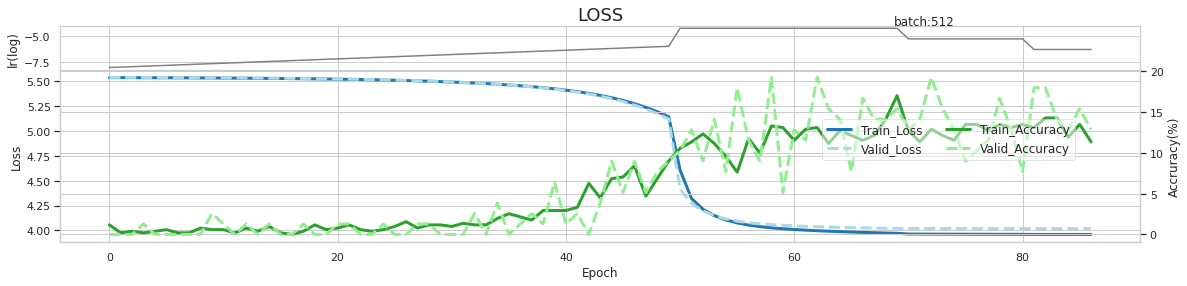

In [36]:
# 作圖
def get_LossFig(figName=None, s=0, e=-1 , savefig=False):
    '''繪製學習過程圖
    Parameters
     ----------
       figName: str, default: None
       s: number(int) , default: 0, start of epoch.  number(int) 
       e: number(int) , default: 0, end of epoch. 
       savefig: boolean
           whether to save
   '''
    log = pd.read_csv(path_model/f'Loss_log_{figName}.csv')
    log = log[s:e] 
    fig = plt.figure(figsize=(15,3))
    ax1 = fig.add_axes([0, 0.0, 1, 0.8],)
    ax2 = plt.twinx()
    ax3 = fig.add_axes([0, 0.8, 1, 0.2], xticklabels=[])

    ax1.plot(log.train_Loss, label='Train_Loss', c='tab:blue', lw=3)
    ax1.plot(log.valid_Loss, label='Valid_Loss', c='lightblue', lw=3, ls='--'  )
    ax2.plot(log.train_Acc, label='Train_Accuracy', c='tab:green', lw=3)
    ax2.plot(log.valid_Acc, label='Valid_Accuracy', c='lightgreen', lw=3, ls='--' )
    ax3.plot(np.log10(log.lr), c='grey')   # lr取log 

    plt.title('LOSS', {'fontsize':18})
    plt.suptitle(f'batch:{batch_size}', x=0.8, y=1.05, fontsize=12, fontweight='light')
    ax1.set_xlabel('Epoch',{'fontsize':12}); ax1.set_ylabel('Loss',{'fontsize':12})
    ax2.set_ylabel('Accruracy(%)',{'fontsize':12}); ax3.set_ylabel('lr(log)',{'fontsize':12})
    ax1.grid(True)
    fig.legend(loc='upper left', ncol=2, bbox_to_anchor=(0.7, 0.6), frameon=True, framealpha=.5, fontsize=12 ) 
    
    # 圖片存檔
    if savefig:       
        plt.savefig(path_model/f'Loss_{figName}.jpg', bbox_inches='tight')
    fig; 
    
get_LossFig(figName=model_name, savefig=True)

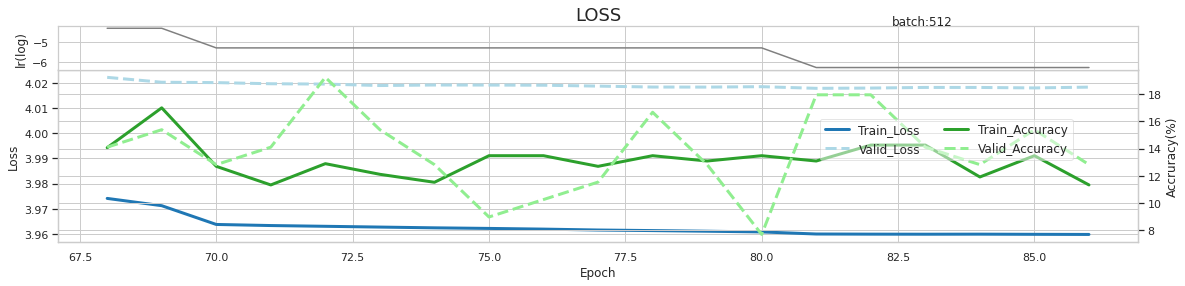

In [37]:
get_LossFig(figName=model_name,  s=-20)

### View the overall classification accuracy rate of the validation data set

In [38]:
# model_name = 'Family_Predictor_Batch500'
print(model_name )
path = path_model/f'{model_name}.pth'

Family_Predictor_Batch512_VSC


In [39]:
%%time

model = load_checkpoint(model, path)

# 檢視驗證資料集整體分類正確率 a
valid_loader = DataLoader(dataset=valid_set, batch_size=1024)
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device) # 把資料送入GPU(非inplace)

        # 計算圖片在每個類別上的分數
        outputs = model(inputs)
        # 得分最高的那個類別
        _, predicted = torch.max(outputs.data, 1)
                
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
#         print(f'total : {total:5d}, correct : {correct:5d}')
#         accuracy = (torch.argmax(outputs, dim=1) == labels).sum().item() / batch_size

print(f'Accuracy of the network on the valid data: {(100 * correct / total):.3f} %, Sample_Size : {total:5,d}')
# 整體分類正確率約為92%

best__metric : 19.2308
Family_Predictor_Batch512_VSC.pth loaded!
Accuracy of the network on the valid data: 11.839 %, Sample_Size : 358,478
CPU times: user 4.12 s, sys: 20.3 ms, total: 4.14 s
Wall time: 4.16 s


In [40]:
# 建立科名encoing的字典對照表 
family_list = list(df_meta.Family.dropna().unique())
family_list.sort()
print(len(family_list))

fam2digit = dict(zip(family_list, range(len(family_list))))


249


In [41]:
%%time
#檢視驗證資料集各類別分類正確率 
classes = [k for k in fam2digit.keys()]
n_classes = len(classes)

class_correct = list(0 for i in range(n_classes))
class_total = list(0 for i in range(n_classes))
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device) # 把資料送入GPU(非inplace)
        
        # 計算圖片在每個類別上的分數
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(outputs.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('Accuracy of each class')         
# for i in range(n_classes):
#     accuracy = 100 * class_correct[i] / (class_total[i] + 1e-10)  # 加上極微小的數值避免分母為0
#     print(f'Family {classes[i]:20s} : {accuracy:6.3f} %')

Accuracy of each class
CPU times: user 31.3 s, sys: 346 ms, total: 31.6 s
Wall time: 31.6 s


In [42]:
acc_df = pd.DataFrame({'Family':classes, 'Correct':class_correct, 'Total':class_total})
acc_df['Accuracy'] = acc_df.Correct / (acc_df.Total + 1e-10)  # 加上極微小的數值避免分母為0
acc_df = acc_df.sort_values(by='Total')[::-1]

logRoot =  "./model/family_Predictor"
LogFile = f'accuracyLog_Batch500'
acc_df.to_csv(path_model/f'{LogFile}.csv', index=True)

acc_df = pd.read_csv(path_model/f'{LogFile}.csv', index_col=0)
acc_df[acc_df.Total>0][:20]
acc_df['cumsum'] = acc_df["Total"].cumsum()
acc_df['Total%'] = acc_df['cumsum'] / acc_df.iloc[-1,-1]
acc_df[:20]

,Family,Correct,Total,Accuracy,cumsum,Total%
240,Tyrannidae,8750,15717,0.556722,15717,0.043844
228,Thraupidae,1149,14169,0.081093,29886,0.083369
235,Trochilidae,7365,13554,0.543382,43440,0.121179
10,Anatidae,7916,10912,0.725440,54352,0.151619
128,Muscicapidae,1628,10898,0.149385,65250,0.182020
2,Accipitridae,4744,10645,0.445655,75895,0.211715
169,Picidae,1616,9637,0.167687,85532,0.238598
80,Furnariidae,132,9236,0.014292,94768,0.264362
53,Columbidae,453,8367,0.054141,103135,0.287702
79,Fringillidae,30,8024,0.003739,111159,0.310086


In [43]:
acc_df.query('Accuracy<0.7').sort_values(by=['Accuracy'])

,Family,Correct,Total,Accuracy,cumsum,Total%
245,Viduidae,0,388,0.000000,343688,0.958742
191,Ptiliogonatidae,0,160,0.000000,352241,0.982601
12,Anhingidae,0,159,0.000000,352400,0.983045
227,Thinocoridae,0,159,0.000000,352559,0.983489
88,Hemiprocnidae,0,159,0.000000,352718,0.983932
...,...,...,...,...,...,...
183,Procellariidae,1388,3391,0.409319,231402,0.645512
102,Laridae,2769,6400,0.432656,131239,0.366101
2,Accipitridae,4744,10645,0.445655,75895,0.211715
235,Trochilidae,7365,13554,0.543382,43440,0.121179


In [44]:
acc_df.sort_values(by=['Accuracy'])[-10:]

,Family,Correct,Total,Accuracy,cumsum,Total%
169,Picidae,1616,9637,0.167687,85532,0.238598
14,Apodidae,535,2849,0.187785,250023,0.697457
163,Phasianidae,1032,5051,0.204316,164663,0.459339
219,Strigidae,1473,6735,0.218708,124839,0.348247
183,Procellariidae,1388,3391,0.409319,231402,0.645512
102,Laridae,2769,6400,0.432656,131239,0.366101
2,Accipitridae,4744,10645,0.445655,75895,0.211715
235,Trochilidae,7365,13554,0.543382,43440,0.121179
240,Tyrannidae,8750,15717,0.556722,15717,0.043844
10,Anatidae,7916,10912,0.725440,54352,0.151619
